# Convolutional Neural Network
* The task is to classify images of Chinese characters.
* Very similar to MNIST, and I used the Model Zoo's MNIST model as a starting point for this: https://github.com/FluxML/model-zoo/tree/master/vision/mnist.
* The  dataset was collected by Ryan Harper (https://github.com/kimrharper) from the web site http://char.iis.sinica.edu.tw for a series of meetups of the Portland Data Science Group.

In [1]:
using Pkg, Images, Plots, Flux

using MLDataUtils: shuffleobs, splitobs
using Glob: glob
using Statistics: mean, std

using Flux: onehotbatch, crossentropy, data, onecold, train!


loaded


In [2]:
# ch_train_set contains 15 directories.  Each directory name is the class
# of the image files in the directory.
#
# a440 a447 a448 a453 a46a a46c a4a3 a4a7 a4bd a4eb a548 a5ce aaf7 b0a8 b6c0

INPUT_DIR = "../input/ch_train_set"

cd(INPUT_DIR)

In [3]:
labels = glob("*")

join(labels, " ")

"a440 a447 a448 a453 a46a a46c a4a3 a4a7 a4bd a4eb a548 a5ce aaf7 b0a8 b6c0"

In [4]:
# Only bother with classes that have at least 150 images.
# (Actually don't need to do this anymore)
labels = [
    label
    for label in glob("*")
    if length(glob(label * "/*")) >= 150
]

join(labels, " ")

"a440 a447 a448 a453 a46a a46c a4a3 a4a7 a4bd a4eb a548 a5ce aaf7 b0a8 b6c0"

In [5]:
# Read the png file and convert to a 2-D Array of floats.
function to_example(fname::String)
    float.(Gray.(load(fname)))
end


to_example (generic function with 1 method)

In [6]:
y_raw = Symbol[]
pngs = []

for label in labels
    
    # Just take the first 150 images
    fnames = glob(label * "/*png")[1:150]
        
    for fname in fnames
        push!(pngs, to_example(fname))
        push!(y_raw, Symbol(label))
    end
end


summary(pngs), summary(y_raw)

("2250-element Array{Any,1}", "2250-element Array{Symbol,1}")

In [7]:
# Each image has 5135 pixels, so 5135 features.
size(pngs[1]), 65*79

((65, 79), 5135)

In [8]:
?cat

search: cat catch catch_backtrace vcat hcat scatter scatter! scatter3d



```
cat(A...; dims=dims)
```

Concatenate the input arrays along the specified dimensions in the iterable `dims`. For dimensions not in `dims`, all input arrays should have the same size, which will also be the size of the output array along that dimension. For dimensions in `dims`, the size of the output array is the sum of the sizes of the input arrays along that dimension. If `dims` is a single number, the different arrays are tightly stacked along that dimension. If `dims` is an iterable containing several dimensions, this allows one to construct block diagonal matrices and their higher-dimensional analogues by simultaneously increasing several dimensions for every new input array and putting zero blocks elsewhere. For example, `cat(matrices...; dims=(1,2))` builds a block diagonal matrix, i.e. a block matrix with `matrices[1]`, `matrices[2]`, ... as diagonal blocks and matching zero blocks away from the diagonal.


In [9]:
# Want X_train to be a 4-dimensional array (tensor) with dimensions:
# H - height of image
# W - width of image
# C - number of channels (only 1 for black and white)
# I - the ith image, out of a total of B in the batch.

# (H x W x C x I)

# "..." is Julia's 'splat operator'
X_raw = cat(pngs..., dims=4)

summary(X_raw)

"65×79×1×2250 Array{Float64,4}"

# Normalize the Data
* The optimizer will apply the same learning rate to all gradients. 
* If inputs are of the same scale (same mean, same stdv) they'll train at more similar rates.


In [10]:
X_means = mean(X_raw, dims=(3,4))

# 21 out of 5135 features have a mean greater than 0.5.
length(X_means[X_means .>  0.5])

21

In [11]:
X_stdevs = std(X_raw, dims=(3,4))

# 24 have a stdev greater than 0.5.
length(X_stdevs[X_stdevs .>  0.5])

24

In [12]:
# Normalization

# Problem: more than 1000 of the features are 0 for all examples.
# Therefore, their standard deviation is 0.  But can't divide by 0,
# so add an ϵ to prevent this.
ϵ = 1e-15 

X_raw_normed = (X_raw .- mean(X_raw, dims=(3,4))) ./ (std(X_raw, dims=(3,4)) .+ ϵ)

summary(X_raw_normed)

"65×79×1×2250 Array{Float64,4}"

In [13]:
X_means = mean(X_raw_normed, dims=(3,4))

# All features now have a mean of about 0.
length(X_means[-0.001 .< X_means .<  0.001])

5135

In [14]:
# And a standard deviation of either 0 or 1.

X_stdevs = std(X_raw_normed, dims=(3,4))

@show length(X_stdevs[.99 .< X_stdevs .< 1.1])
@show length(X_stdevs[-0.1 .< X_stdevs .< 0.1])

3948 + 1187

length(X_stdevs[0.99 .< X_stdevs .< 1.1]) = 3948
length(X_stdevs[-0.1 .< X_stdevs .< 0.1]) = 1187


5135

In [15]:
# onehotbatch will onehot encode an array of values.
y_raw_onehot = onehotbatch(y_raw, sort(unique(y_raw)))

# There are 15 different character types.
# This is before shuffling, so images 1-5 are all class 1, et.


15×2250 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
  true   true   true   true   true  …  false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false  …  false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false  …  false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false     false  false  false  false  fa

In [16]:
# Shuffle the examples (observations)
Xs, ys = shuffleobs((X_raw_normed, y_raw_onehot))

# Split them into training and test sets.
(X_train, y_train), (X_test, y_test) = splitobs((Xs, ys); at=2/3)
    
@show size(X_train)
@show size(y_train)
@show size(X_test)
@show size(y_test);

size(X_train) = (65, 79, 1, 1500)
size(y_train) = (15, 1500)
size(X_test) = (65, 79, 1, 750)
size(y_test) = (15, 750)


In [17]:
# if CuArrays (Cuda Arrays) package is installed, then 
# Flux will write arrays to GPU ram when those arrays are 
# fed to the gpu function.

if "CuArrays" in keys(Pkg.installed())
    using CuArrays
    println("using GPU.")
else
    println("No GPU available.")
end


No GPU available.


In [18]:
# shuffleobs and splitobs create view objects on the original arrays.
# Flux needs a real array object (I think).

# Feed the output to the gpu() function, to be written to the 
# GPU.  If no GPU available, then gpu() does nothing.
X_train_copy = copy(X_train) |> gpu
y_train_onehot = y_train |> gpu

X_test_copy = copy(X_test) |> gpu
y_test_onehot = copy(y_test) |> gpu

summary(y_test_onehot)

"15×750 Array{Bool,2}"

In [19]:
# Last minute change.  Break up the one big batch into minibatches, may train 
# faster because all data doesn't need to be in RAM at once.
using Base.Iterators

train = [
    (X_train_copy[:, :, :, indices], y_train_onehot[:, indices]) for indices in partition(1:1500, 25)
]


summary(train), summary(train[1]), summary(train[1][1])

("60-element Array{Tuple{Array{Float64,4},Array{Bool,2}},1}", "Tuple{Array{Float64,4},Array{Bool,2}}", "65×79×1×25 Array{Float64,4}")

In [20]:
# Create a CNN model using layers: Conv, maxpool, Dense, etc.
# Fairly Keras like, except must specify dimensions.

model = Chain(
   Conv((2,2), 1=>16, relu),
   x -> maxpool(x, (2,2)),
    
   Conv((2,2), 16=>8, relu),
   x -> maxpool(x, (2,2)),
    
   x -> reshape(x, :, size(x, 4)),
    
   Dense(2280, 15), 
  
   softmax
) |> gpu

Chain(Conv((2, 2), 1=>16, NNlib.relu), getfield(Main, Symbol("##9#12"))(), Conv((2, 2), 16=>8, NNlib.relu), getfield(Main, Symbol("##10#13"))(), getfield(Main, Symbol("##11#14"))(), Dense(2280, 15), NNlib.softmax)

In [21]:
loss(x, y) = crossentropy(model(x), y)

loss (generic function with 1 method)

In [22]:
# Using cpu() function to write output of onecold(y) back to CPU ram, 
# to match output of onecold(model(x)).  Will throw error otherwise - 
# trying to compare an array on the CPU ram with Array on GPU ram.

accuracy(x, y) = mean(onecold(model(x)) .== cpu(onecold(y)))



accuracy (generic function with 1 method)

In [23]:
# Create an ADAM optimizer to update parameters.

optimizer = ADAM(params(model)) |> gpu

#43 (generic function with 1 method)

In [24]:
losses = []
accuracies = []
test_accuracies = []

0-element Array{Any,1}

0.8506666666666667
0.9186666666666666
0.9226666666666666


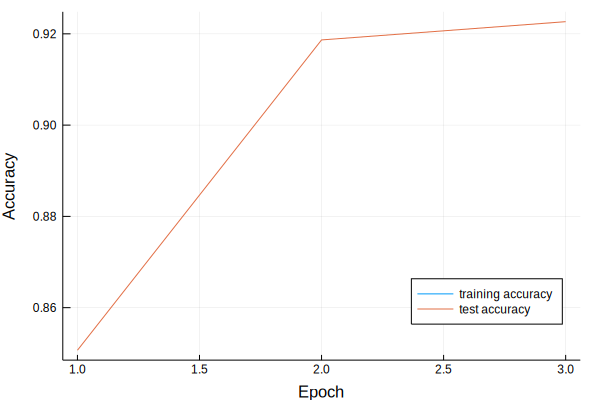

In [25]:

for epoch in 1:3
    train!(loss, train, optimizer)

    push!(test_accuracies, accuracy(X_test_copy, y_test_onehot))
    println(last(test_accuracies))
end    


plot!(test_accuracies, label="test accuracy", legend=:bottomright)

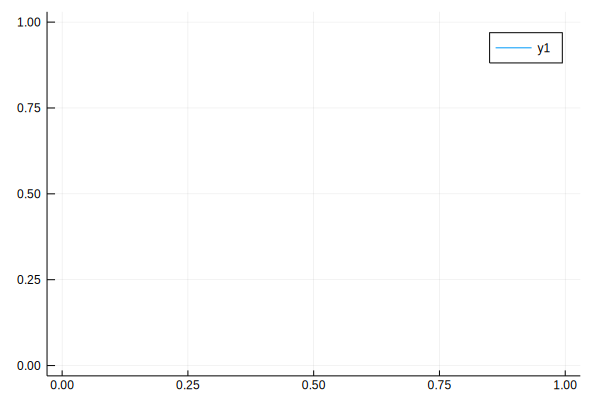

In [26]:
plot(losses)